# Apriltag detection

Here, we provide some sample code for Apriltag detection and subsequent location estimation. First, we load the Fusiontest data, which has Apriltags within it.


In [17]:
from pyneon import get_sample_data, NeonDataset, NeonRecording

# Download sample data (if not existing) and return the path
sample_dir = "C:/Users/jan-gabriel.hartel/Documents/GitHub/PyNeon/data/FusionTest"
print(sample_dir)

dataset_dir = sample_dir
recording = NeonRecording(dataset_dir)

C:/Users/jan-gabriel.hartel/Documents/GitHub/PyNeon/data/FusionTest


# Explanation of the Tag Position and Orientation Data

### 1. Coordinate System Definition
- The origin `(0, 0, 0)` is defined at the center of the whiteboard.
- The coordinate axes are as follows:
  - **x-axis**: Points **forward**, away from the board toward the camera.
  - **y-axis**: Points **to the left** along the board’s surface.
  - **z-axis**: Points **up** along the board’s surface.

This setup ensures that any point `(x, y, z)` describes the tag’s position relative to the board's center.

---

### 2. Tag Position `(x, y, z)`
- Each tag’s position is specified in meters relative to the board’s origin.
- Example for `tag_id: 0`:
  - `x = 0.0` m → The tag is at the center of the board in the forward/backward direction.
  - `y = -0.25` m → The tag is **0.25 m to the right** of the board's center (negative \(y\) indicates right).
  - `z = 0.2` m → The tag is **0.2 m above** the board's center.

---

### 3. Tag Orientation (Normal Vector)
- The normal vector `(normal_x, normal_y, normal_z)` describes the orientation of the tag.
- In this setup, the whiteboard is in the plane defined by `(y, z)`, so tags generally face outward along the \(x\)-axis:
  - `normal_x = 1` → The tag faces directly along the positive \(x\)-axis.
  - `normal_y = 0`
  - `normal_z = 0`
- If a tag were tilted or angled, these normal values would reflect its orientation in 3D space.

---

### 4. Tag Size
- `size` specifies the side length of the printed tag, in meters.
- Example for `tag_id: 0`:
  - `size = 0.075` m → Each side of the tag is 7.5 cm.

---

### 5. Usage in Calculating Camera Position
- Using the known position `(x, y, z)` and orientation (the normals) of each tag, the AprilTag detection system can estimate the camera’s position.
- When the camera detects at least one tag:
  - It uses the tag’s position and orientation to determine its own position in the same coordinate system.
  - Detecting multiple tags improves the precision of the camera's pose estimation.

---

In summary:
- **Position** `(x, y, z)` describes the tag's location relative to the origin.
- **Orientation** `(normal_x, normal_y, normal_z)` describes the tag’s facing direction.
- **Size** specifies the physical dimensions of the tag.
- This data allows the system to calculate the camera's position and orientation whenever tags are detected.


In [18]:
import pandas as pd

data = [
    {
        "tag_id": 0,
        "x": 0.0,
        "y": -0.25,
        "z": 0.2,
        "normal_x": 1,
        "normal_y": 0,
        "normal_z": 0,
        "size": 0.075,
    },
    {
        "tag_id": 1,
        "x": 0.0,
        "y": 0.25,
        "z": 0.2,
        "normal_x": 1,
        "normal_y": 0,
        "normal_z": 0,
        "size": 0.075,
    },
    {
        "tag_id": 2,
        "x": 0.0,
        "y": -0.25,
        "z": -0.2,
        "normal_x": 1,
        "normal_y": 0,
        "normal_z": 0,
        "size": 0.075,
    },
    {
        "tag_id": 3,
        "x": 0.0,
        "y": 0.25,
        "z": -0.2,
        "normal_x": 1,
        "normal_y": 0,
        "normal_z": 0,
        "size": 0.075,
    },
]

tags_df = pd.DataFrame(data)

camera_position = recording.estimate_camera_pose(tags_df)
print(camera_position.columns)

Index(['frame_idx', 'translation_vector', 'rotation_vector', 'camera_pos'], dtype='object')


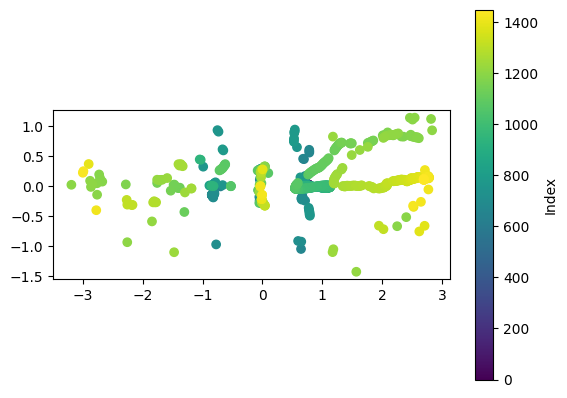

In [19]:
# plot the trajectory in xy

import matplotlib.pyplot as plt
import numpy as np

x = camera_position["camera_pos"].apply(lambda x: x[0]).values  # Extract x values
y = camera_position["camera_pos"].apply(lambda x: x[1]).values  # Extract y values
colors = np.arange(len(x))  # Create a color array based on the index

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=colors, cmap="viridis")
plt.colorbar(scatter, label="Index")
ax.set_aspect("equal", "box")
plt.show()

# Using a Kalman Filter to Smooth Camera Pose Estimation

### Why Use a Kalman Filter?
The Kalman filter is applied to smooth the camera's estimated position, which can be noisy or imprecise due to:
- Measurement errors in detecting AprilTags.
- Variability in pose estimation caused by camera movement or tracking noise.

By combining predictions from a motion model with actual measurements, the Kalman filter reduces these errors and provides a more reliable trajectory.

---

### How the Kalman Filter Works
1. **Prediction Step**:
   - Predicts the next camera position based on its previous state and a simple motion model.
   - Accounts for process noise (uncertainty in the motion).

2. **Correction Step**:
   - Updates the predicted position using measurements (detected tag positions).
   - Weights the prediction and measurement based on their respective uncertainties (process vs. measurement noise).
   - Ignores outlier measurements using a gating threshold (e.g., based on Mahalanobis distance).

---

### Key Parameters
- **Initial State Noise** (`initial_state_noise`): Defines the initial uncertainty in the camera's position.
- **Process Noise** (`process_noise`): Models the uncertainty in the camera's motion.
- **Measurement Noise** (`measurement_noise`): Models the error in AprilTag detections.
- **Gating Threshold** (`gating_threshold`): Filters out unlikely measurements to avoid introducing significant errors.

---

### Benefits
- Smooths out sudden jumps or jitter in the camera's estimated trajectory.
- Handles missing detections by propagating predictions in the absence of measurements.
- Improves accuracy, especially in scenarios with inconsistent tag detection.

This approach ensures a more stable and realistic trajectory for the camera, minimizing the impact of measurement noise on pose estimation.


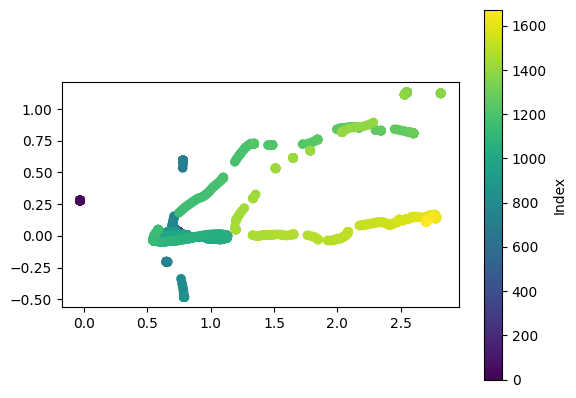

In [20]:
camera_position = recording.smooth_camera_pose(
    initial_state_noise=0.1,
    process_noise=0.005,
    measurement_noise=0.005,
    gating_threshold=2,
)


# plot the trajectory in xy

import matplotlib.pyplot as plt
import numpy as np

x = (
    camera_position["smoothed_camera_pos"].apply(lambda x: x[0]).values
)  # Extract x values
y = (
    camera_position["smoothed_camera_pos"].apply(lambda x: x[1]).values
)  # Extract y values
colors = np.arange(len(x))  # Create a color array based on the index

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=colors, cmap="viridis")
plt.colorbar(scatter, label="Index")
ax.set_aspect("equal", "box")
plt.show()